In [16]:
"""
BIOSTREAM 13: uncertainty analysis w/ Model object (sets parameter values, samples from parameter distributions,
reevaluates biorefinery metrics at each condition)"""

from chaospy import distributions as shape

#triangular distribution: continuous w/ a <= c <= b, where c is the mode
#triangular distribution used when limits unsure but 
lower_bound = 0
most_probable = 0.5
upper_bound = 1
triang = shape.Triangle(lower_bound, most_probable, upper_bound)
print(triang)

Triangle(lower=0, midpoint=0.5, upper=1)


In [2]:
#uniform distribution when theoretical limits known but no way to know what most probably
unif = shape.Uniform(lower_bound, upper_bound)
print(unif)

Uniform(lower=0, upper=1)


In [17]:
# Parameter objects: manage parameter values/distributions
    # define setter [function], the Parameter object uses to set element (unit operation, stream)
    # pass chaospy distribution for Model object to sample from
from biorefineries import lipidcane as lc
import biosteam as bst

#create a model object
solve_IRR = lc.lipidcane_tea.solve_IRR
total_utility_cost = lambda: lc.lipidcane_tea.utility_cost / 10**6 #results 10^6 usd/yr
metrics = (bst.Metric('Internal rate of return', lc.lipidcane_tea.solve_IRR, '%'),
           bst.Metric('Utility cost', total_utility_cost, '10^6 USD/yr'))
model = bst.Model(lc.lipidcane_sys, metrics)

In [19]:
#add design parameter: Unit attribute that DOES NOT affect mass and energy balances
R301 = bst.main_flowsheet.unit.R301 # The Fermentation Unit
@model.parameter(name='Number of reactors',
                 element=R301, kind='design',
                 distribution=shape.Uniform(4, 10))
def set_N_reactors(N):
    R301.N = round(N) #adds N fermentation reactors as design parameter
parameters = model.get_parameters()

#calling parameter updates the parameter / results
set_N_reactors_parameter = parameters[0]
set_N_reactors_parameter(5)
print(f'Puchase cost at 5 reactors: ${R301.purchase_cost:,.0f}')
set_N_reactors_parameter(8)
print(f'Puchase cost at 8 reactors: ${R301.purchase_cost:,.0f}')

Puchase cost at 5 reactors: $1,719,417
Puchase cost at 8 reactors: $2,031,413


In [20]:
#add cost parameters: does not change design requirements
# example, change unit base cost as cost parameter
reactors_cost_coefficients = R301.cost_items['Reactors']
mid = reactors_cost_coefficients.n # Most probable at baseline value
lb = mid - 0.1 # Minimum
ub = mid + 0.1 # Maximum
@model.parameter(element=R301, kind='cost',
                 distribution=shape.Triangle(lb, mid, ub))
def set_exponential_cost_coefficient(exponential_cost_coefficient):
    reactors_cost_coefficients.n = exponential_cost_coefficient
model.get_parameters()

(<Parameter: [Fermentation-R301] Number of reactors>,
 <Parameter: [Fermentation-R301] Exponential cost coefficient>)

In [21]:
#can also add isolated parameter: doesnt affect unit objects at all
#for example change feedstock price
lipidcane = lc.lipidcane # The feedstock stream
lb = lipidcane.price * 0.9 # Minimum price
ub = lipidcane.price * 1.1 # Maximum price
@model.parameter(element=lipidcane, kind='isolated', units='USD/kg',
                 distribution=shape.Uniform(lb, ub))
def set_feed_price(feedstock_price):
    lipidcane.price = feedstock_price

#couples parameter DOES affect mass and energy balance
from biorefineries.lipidcane.utils import set_lipid_fraction
# Note that if the setter function is already made, you can pass it as the first argument
set_lipid_fraction = model.parameter(set_lipid_fraction,
                                     element=lipidcane, kind='coupled',
                                     distribution=shape.Uniform(0.05, 0.10))
#as another example, add fermentation efficiency as a coupled parameter:
@model.parameter(element=R301, kind='coupled',
                 distribution=shape.Triangle(0.85, 0.90, 0.95))
def set_fermentation_efficiency(efficiency):
    R301.efficiency = efficiency
model

Model: Biorefinery internal rate of return [%]
       Biorefinery utility cost [10^6 USD/yr]
 Element:           Parameter:
 Stream-lipidcane   Lipid fraction
 Fermentation-R301  Efficiency
                    Number of reactors
                    Exponential cost coefficient
 Stream-lipidcane   Feedstock price


In [22]:
#return DataFrame object of parameter distributions
df_dct = model.get_distribution_summary()
df_dct['Uniform']
df_dct['Triangle']

,Element,Name,Units,Shape,lower,midpoint,upper
0,Fermentation-R301,Efficiency,,Triangle,0.85,0.9,0.95
1,Fermentation-R301,Exponential cost coefficient,,Triangle,0.4,0.5,0.6


In [23]:
#next, evaluate metric at a given sample. For example, returns two metrics
# (IRR, utility cost)
model([0.05, 0.85, 8, 100000, 0.040])

/Users/hellpark/.local/lib/python3.7/site-packages/biosteam/units/design_tools/pressure_vessel.py:85: UserWarning: vacuum pressure vessel ASME codes not implemented yet; wall thickness may be inaccurate and stiffening rings may be required
  warn('vacuum pressure vessel ASME codes not implemented yet; '


Biorefinery  Internal rate of return [%]   0.102
             Utility cost [10^6 USD/yr]      -18
dtype: float64

In [24]:
# finally, sample from a joint distribution: 
N_samples = 100
rule = 'L' # For Latin-Hypercube sampling
samples = model.sample(N_samples, rule)
model.load_samples(samples)
model.evaluate()
model.table # All evaluations are stored as a pandas DataFrame

/Users/hellpark/.local/lib/python3.7/site-packages/biosteam/units/design_tools/pressure_vessel.py:85: UserWarning: vacuum pressure vessel ASME codes not implemented yet; wall thickness may be inaccurate and stiffening rings may be required
  warn('vacuum pressure vessel ASME codes not implemented yet; '
/Users/hellpark/.local/lib/python3.7/site-packages/biosteam/units/design_tools/pressure_vessel.py:85: UserWarning: vacuum pressure vessel ASME codes not implemented yet; wall thickness may be inaccurate and stiffening rings may be required
  warn('vacuum pressure vessel ASME codes not implemented yet; '
/Users/hellpark/.local/lib/python3.7/site-packages/biosteam/units/design_tools/pressure_vessel.py:85: UserWarning: vacuum pressure vessel ASME codes not implemented yet; wall thickness may be inaccurate and stiffening rings may be required
  warn('vacuum pressure vessel ASME codes not implemented yet; '


Element  Stream-lipidcane Fermentation-R301                     \
Variable   Lipid fraction        Efficiency Number of reactors   
0                  0.0678             0.913               6.74   
1                  0.0874              0.91               4.82   
2                  0.0674             0.903               5.05   
3                  0.0839             0.859               6.16   
4                  0.0558             0.875                  8   
..                    ...               ...                ...   
95                  0.081             0.915               6.46   
96                 0.0966             0.919               8.79   
97                 0.0608             0.895               6.27   
98                 0.0667             0.871               7.92   
99                  0.069             0.907               8.73   

Element                                       Stream-lipidcane  \
Variable Exponential cost coefficient Feedstock price [USD/kg]   
0                               0.522                   0.0374   
1                               0.576                   0.0377   
2                               0.489                   0.0348   
3                               0.547                   0.0327   
4                               0.555                   0.0359   
..                                ...                      ...   
95                              0.531                   0.0369   
96                              0.559                   0.0312   
97                              0.491                   0.0358   
98                              0.502                   0.0371   
99                              0.509                   0.0335   

Element                  Biorefinery                             
Variable Internal rate of return [%] Utility cost [10^6 USD/yr]  
0                              0.144                      -20.5  
1                              0.158                        -24  
2                              0.156                      -20.6  
3                              0.172                      -23.8  
4                              0.135                      -18.8  
..                               ...                        ...  
95                             0.157                      -22.9  
96                             0.194                      -25.6  
97                             0.144                      -19.5  
98                             0.137                      -20.7  
99                             0.164                      -20.8  

[100 rows x 7 columns]

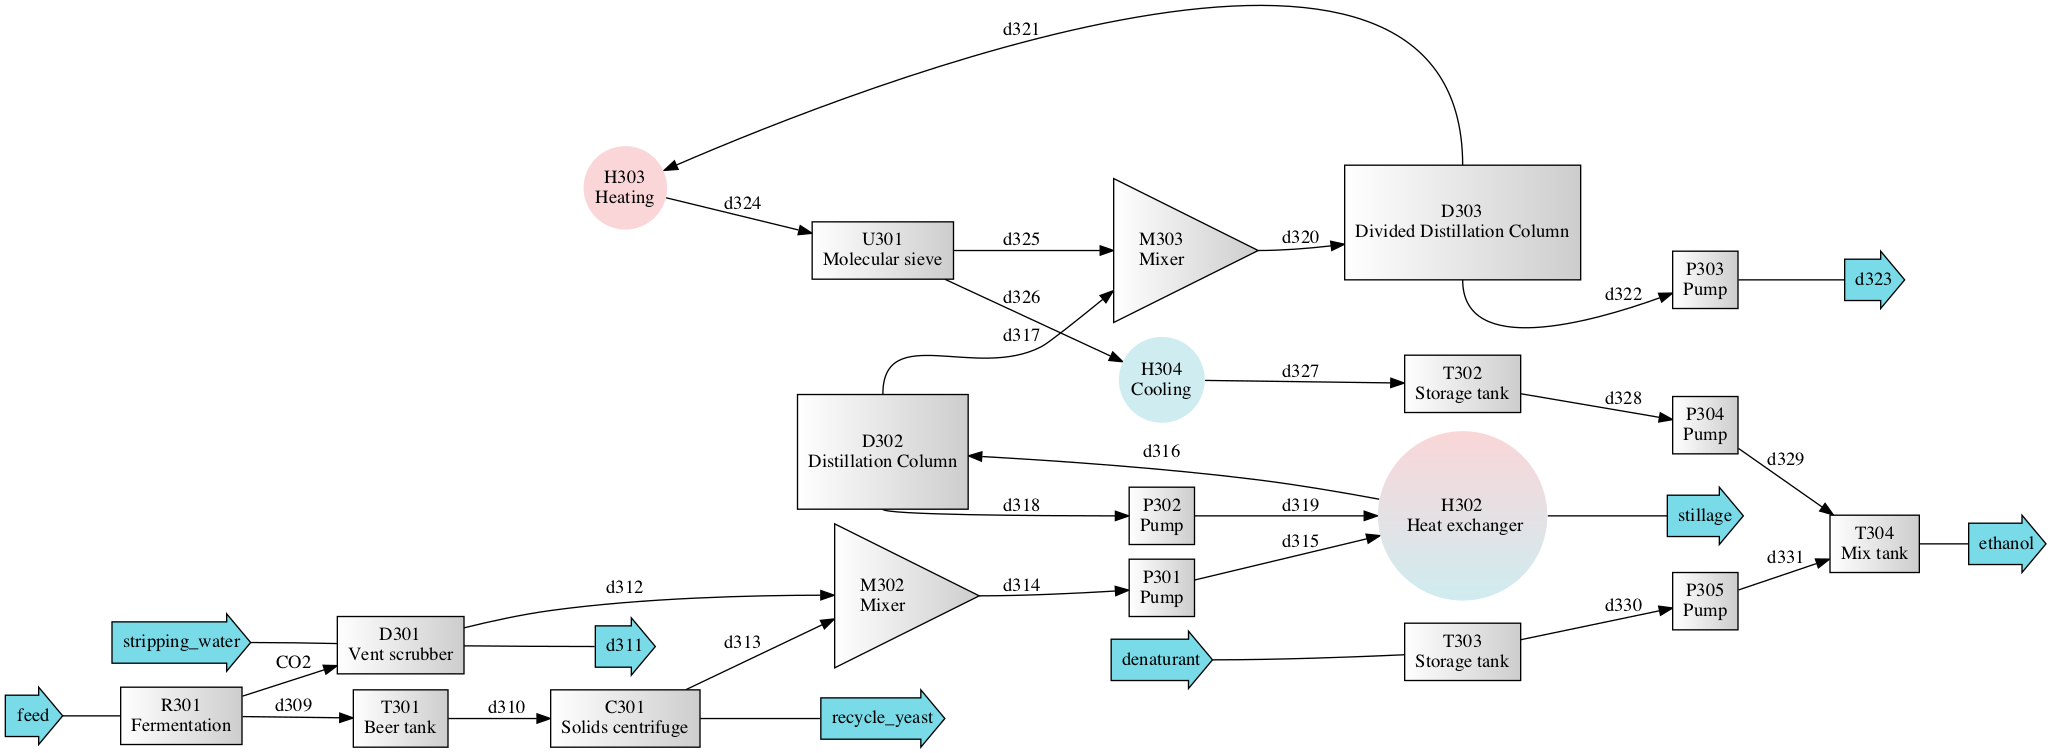

In [25]:
"""TRY: Titer, pRoductivity, Yield are main parameters that impact economics"""

import numpy as np
import biosteam as bst
from biosteam import units, main_flowsheet as F
from biorefineries import sugarcane as sc
bst.settings.set_thermo(sc.chemicals)

#sugarcane ehtanol plant fermentation and downstream separation
# Ethanol Production
feed = bst.Stream('feed',
           Glucose=3.8e+03,
           Sucrose=4.31e+04,
           Water=1.03e+05,
           DryYeast=1.03e+04,
           H3PO4=83.3,
           units='kg/hr',
           T=295.98)
R301 = units.Fermentation('R301', feed, ('CO2', ''), tau=9, efficiency=0.90, N=4)
T301 = units.StorageTank('T301', tau=4, vessel_material='Carbon steel')
T301.line = 'Beer tank'

stripping_water = bst.Stream('stripping_water', Water=5000, units='kg/hr')
D301 = units.VentScrubber('D301', ins=(stripping_water, R301-0), gas=('CO2',))

# Separate 99% of yeast
C301 = units.SolidsCentrifuge('C301', outs=('', 'recycle_yeast'),
                            split=(1, 0.99999, 1, 0.96, 0.01),
                            order=('Ethanol', 'Glucose', 'H3PO4',
                                   'Water', 'DryYeast'),
                            solids=('DryYeast',))

# Mix in Water
M302 = units.Mixer('M302')
P301 = units.Pump('P301')

# Heat up before beer column
# Exchange heat with stillage
H302 = units.HXprocess('H302', outs=('', 'stillage'),
                      phase0='l', phase1='l', U=1.28)
# Beer column
xbot = 5e-06
ytop = 0.345
D302 = units.BinaryDistillation('D302', P=101325,
                            y_top=ytop, x_bot=xbot, k=1.25,
                            LHK=('Ethanol', 'Water'))
D302.tray_material = 'Stainless steel 304'
D302.vessel_material = 'Stainless steel 304'
D302.boiler.U = 1.85
P302 = units.Pump('P302')

# Mix ethanol Recycle (Set-up)
M303 = units.Mixer('M303')

ytop = 0.79
D303 = units.BinaryDistillation('D303', P=101325,
                            y_top=ytop, x_bot=xbot, k=1.25,
                            LHK=('Ethanol', 'Water'),
                            tray_material='Stainless steel 304',
                            vessel_material='Stainless steel 304',
                            is_divided=True)
D303.boiler.U = 1.85
P303 = units.Pump('P303')

# Superheat vapor for mol sieve
H303 = units.HXutility('H303', T=115+273.15, V=1)

# Molecular sieve
U301 = units.MolecularSieve('U301',
                            split=(2165.14/13356.04, 1280.06/1383.85),
                            order=('Ethanol', 'Water'))
# Condense ethanol product
H304 = units.HXutility('H304', 'S149', V=0, T=340.)
T302 = units.StorageTank('T302', tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P304 = units.Pump('P304')

# Storage for gasoline
denaturant = bst.Stream('denaturant', Octane=230.69,
                        units='kg/hr', price=0.756)
T303 = units.StorageTank('T303', denaturant, tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P305 = units.Pump('P305')

# Denatured ethanol product
ethanol = bst.Stream('ethanol', price=0.789)
T304 = units.MixTank('T304', outs=ethanol)
T304.tau = 0.10
def adjust_denaturant():
    pure_ethanol = P304.outs[0]
    denaturant.imol['Octane'] = 0.021*pure_ethanol.F_mass/114.232
    T304._run()
T304.specification = adjust_denaturant

# Multi-effect evaporator pumps
P306 = units.Pump('P306')


### Ethanol system set-up ###

R301-1-T301-0-C301
(C301-0, D301-1)-M302-P301
(P301-0, P302-0)-H302-0-D302-1-P302
(D302-0, U301-0)-M303-0-D303-0-H303-U301
D303-1-P303

U301-1-H304-0-T302-0-P304
denaturant-T303-P305
(P305-0, P304-0)-T304

## System ###

ethanol_production_sys = bst.System('ethanol_prodution_sys',
                             [R301,
                              T301,
                              C301,
                              M302,
                              P301,
                              bst.System('beer_column_heat_integration',
                                  [H302,
                                   D302,
                                   P302],
                                  recycle=P302-0),
                              bst.System('ethanol_recycle_from_molecular_sieves',
                                  [M303,
                                   D303,
                                   H303,
                                   U301],
                                  recycle=U301-0),
                              H304,
                              T302,
                              P304,
                              T303,
                              P305,
                              T304,
                              D301,
                              P303])
ethanol_production_sys.simulate()
# Create a TEA object with the same specifications
# used for the sugarcane biorefinery.
ethanol_production_tea = sc.create_tea(ethanol_production_sys)

ethanol_production_sys.diagram('thorough')

In [26]:
#next, set ReactorSpecification object to set titer, productivity, and yield
#note, listed below are the DEFAULT values for load_specifications method:
R301 = F('R301') # Fermentor
yearly_production = 125000 # ton/yr
spec = bst.process_tools.ReactorSpecification(
    reactor=R301,
    reaction_name='fermentation_reaction',
    substrates=('Sucrose', 'Glucose'),
    products=('Ethanol',),
    yield_=0.90,
    titer=150,
    productivity=18.5,
    production=yearly_production / 24 / ethanol_production_tea.operating_days * 907.185)

# Calculate titer in g / L
effluent = R301.outs[1]
effluent.imass['Ethanol'] / effluent.F_vol

165.53435207207272

In [27]:
#load in default values
spec.load_specifications(yield_=0.80)

# Recalculate titer in g / L
effluent = R301.outs[1]
effluent.imass['Ethanol'] / effluent.F_vol

#vlaue of 150 is what we specified, titer was solved numerically by adjusting concentration of sugars in feed
# that is how the specification is set up. but can make own version of specification 
# (subclass from reactor specification) 

149.99999571333447

In [28]:
# evaluate_across_TRY method: vectorized across titers nd yields (get cost across range of productivities)
# titer [Y x T], yield [Y x T], metrics [M], productivities [P]
        #would give: results [Y x T x M x P]
titer = 150.
yield_ = 0.90
productivities = np.array([10, 20])
def get_sugar_price():
    substrates = ('Glucose', 'Sucrose')
    feed.price = ethanol_production_tea.solve_price(feed)
    return feed.price / feed.get_mass_composition(substrates).sum() * 907.185
get_installed_equipment_cost = lambda: ethanol_production_tea.installed_equipment_cost / 1e6
metrics = (get_sugar_price, get_installed_equipment_cost) 

#notice above metrics is built with a function

# Return a 2d array with metrics indexed by row and productivities by column
spec.evaluate_across_TRY(ethanol_production_sys, titer, yield_, metrics, productivities)



array([[278.038, 279.536],
       [ 24.775,  23.099]])

In [ ]:
titers = np.linspace(10, 200, 20)
yields = np.linspace(0.50, 0.999, 20)
titers, yields = np.meshgrid(titers, yields)
data = spec.evaluate_across_TRY(ethanol_production_sys, titers, yields, metrics, productivities)
assert data.shape == (*titers.shape, len(metrics), len(productivities)) # Note how the dimensions match

